In [1]:
import numpy as np
import pandas as pd
from matminer.featurizers.composition import ElementProperty, Stoichiometry 
from matminer.featurizers.composition import ValenceOrbital, IonProperty, AtomicOrbitals
from matplotlib import pyplot as plt
from matminer.datasets import load_dataset
from matminer.featurizers.base import MultipleFeaturizer

from matminer.featurizers.conversions import DictToObject, StrToComposition
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy import stats
from tqdm import tqdm_notebook as tqdm

from pymatgen.core.composition import Composition

## Predicting from compositon

In [2]:
df_train=pd.read_csv('data/composition/train.csv',usecols=['formula', 'kpoint_length_unit'])
df_test=pd.read_csv('data/composition/test.csv',usecols=['formula', 'kpoint_length_unit'])

ValueError: Usecols do not match columns, columns expected but not found: ['kpoint_length_unit']

In [406]:
index_nan=[]
for i,form in enumerate(df_train['formula'].values):
    try:
        Composition(form)
    except:
        index_nan.append(i)

In [407]:
index_nan

[7386]

In [408]:
len(df_train)

37284

In [409]:
df_train=df_train.drop(index=index_nan)
df_train.reset_index(drop=True,inplace=True)

In [410]:
exclude_index=[]
for i,value in enumerate(df_train['kpoint_length_unit'].values):
    try:
        df_train.iloc[i]['kpoint_length_unit']=float(value)
    except:
        exclude_index.append(i)
df_train=df_train.drop(index=exclude_index)
df_train.reset_index(drop=True,inplace=True)

/var/folders/v7/cqz0y8fn2sjc927rqlt460_m0000gp/T/ipykernel_31699/1982325088.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.iloc[i]['kpoint_length_unit']=float(value)


In [411]:
exclude_index=[]
for i,value in enumerate(df_test['kpoint_length_unit'].values):
    try:
        df_test.iloc[i]['kpoint_length_unit']=float(value)
    except:
        exclude_index.append(i)
        
df_test=df_test.drop(index=exclude_index)
df_test.reset_index(drop=True,inplace=True)

/var/folders/v7/cqz0y8fn2sjc927rqlt460_m0000gp/T/ipykernel_31699/3638291205.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.iloc[i]['kpoint_length_unit']=float(value)


In [412]:
df_train['composition']=[Composition(df_train.iloc[i]['formula']).fractional_composition for i in range(len(df_train))]
df_test['composition']=[Composition(df_test.iloc[i]['formula']).fractional_composition for i in range(len(df_test))]

In [413]:
featurizer = MultipleFeaturizer([
    ElementProperty.from_preset('magpie'),
    Stoichiometry(),
    ValenceOrbital()
])
flen=len(featurizer.featurize(df_train['composition'][0]))
features_train=np.zeros((len(df_train),flen))
features_test=np.zeros((len(df_test),flen))
for i,comp in enumerate(df_train['composition']):
    features_train[i,:]=featurizer.featurize(comp)
for i,comp in enumerate(df_test['composition']):
    features_test[i,:]=featurizer.featurize(comp)
features_train=np.nan_to_num(features_train, copy=True, nan=0.0, posinf=None, neginf=None)
features_test=np.nan_to_num(features_test, copy=True, nan=0.0, posinf=None, neginf=None)

/opt/miniconda3/envs/llm/lib/python3.12/site-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)
/opt/miniconda3/envs/llm/lib/python3.12/site-packages/matminer/featurizers/composition/orbital.py:115: UserWarning: ValenceOrbital(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the av

In [414]:
ytrain=np.array(df_train['kpoint_length_unit'].values,dtype='float')
ytest=np.array(df_test['kpoint_length_unit'].values,dtype='float')
Xtrain=features_train
Xtest=features_test

In [415]:
from sklearn.ensemble import RandomForestRegressor

In [416]:
RF=RandomForestRegressor()

In [417]:
RF.fit(Xtrain,ytrain)

RandomForestRegressor()

In [418]:
ypred=RF.predict(Xtest)

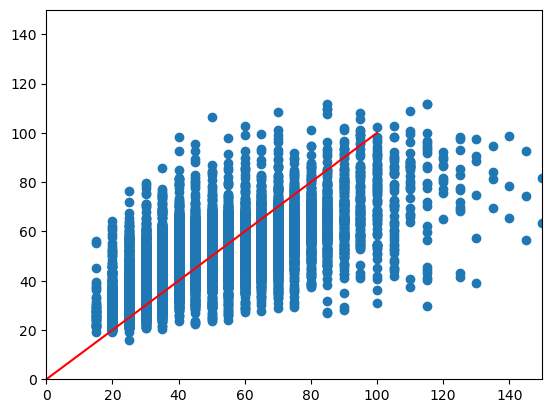

In [419]:
plt.scatter(ytest,ypred)
plt.plot([0,100],[0,100],color='red')
plt.xlim(0,150)
plt.ylim(0,150)
plt.show()

In [420]:
from sklearn.metrics import r2_score
r2_score(ytest,ypred)

0.5115977989587855

In [421]:
from ase.visualize import view
view(structure, viewer='x3d')